# Code adapted from
* https://dzlab.github.io/dltips/en/pytorch/torchtext-datasets/ to use custom dataset
* https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/3%20-%20Faster%20Sentiment%20Analysis.ipynb to use model

In [1]:
CLASS_WEIGHT= 0.12744395919192275

In [2]:
def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

In [3]:
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  preprocessing = generate_bigrams)

LABEL = data.LabelField(dtype = torch.float)

In [4]:
BATCH_SIZE = 128#64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train, val, test = data.TabularDataset.splits(
    path='./data', train='Train.csv',
    validation='Val.csv', test='Test.csv', format='csv',
    fields=[('text', TEXT),(None, None), ('label', LABEL)],
    skip_header = True)# ignore helpfulness column
    # columns are Text, helpfulness, and rating

train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train, val, test), batch_sizes=(BATCH_SIZE,BATCH_SIZE,BATCH_SIZE),
    sort_key=lambda x: len(x.text), device = device)

In [5]:
MAX_VOCAB_SIZE = 50_000

TEXT.build_vocab(train, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
                
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        
        #pooled = [batch size, embedding_dim]
                
        return self.fc(pooled)

In [7]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

#model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

In [8]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc, rounded_preds

In [9]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    preds=[]
    labels=[]
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc, rounded_preds = binary_accuracy(predictions, batch.label)
        preds.extend(rounded_preds.detach().to('cpu').numpy())
        labels.extend(batch.label.detach().to('cpu').numpy())
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), preds, labels

In [10]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    preds=[]
    labels=[]
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            
            acc, rounded_preds = binary_accuracy(predictions, batch.label)
            preds.extend(rounded_preds.detach().to('cpu').numpy())
            labels.extend(batch.label.detach().to('cpu').numpy())
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), preds, labels

In [11]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
from tqdm.notebook import  tqdm

In [13]:
import torch.optim as optim


def train_model(adam=0,lr=0.001,epochs=5):
    # use base adam if adam <=0.5 otherwise use adamW with weight decay
    model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data.copy_(pretrained_embeddings)
    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
    model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
    
    optimizer = optim.Adam(model.parameters(),lr=lr) if adam<=0.5 else optim.AdamW(model.parameters(),lr=lr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([CLASS_WEIGHT]))
    model = model.to(device)
    criterion = criterion.to(device)
    N_EPOCHS = round(epochs)
    #best_valid_loss = float('inf')
    start_time = time.time()
    for epoch in tqdm(range(N_EPOCHS)):

        

        train_loss, train_acc, t_preds, t_labels = train(model, train_iter, optimizer, criterion)
        valid_loss, valid_acc, v_preds, v_labels = evaluate(model, val_iter, criterion)
        f1 = f1_score(v_labels, v_preds, average="macro")
       
        #print('gt: {}'.format(np.unique(v_labels)))
        #print('preds: {}'.format(np.unique(v_preds)))
        
       # if valid_loss < best_valid_loss:
       #     best_valid_loss = valid_loss
       #     torch.save(model.state_dict(), 'sentiment.pt')
        
        #print(f'Epoch: {epoch+1:02}')# | Epoch Time: {epoch_mins}m {epoch_secs}s'
        #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print('F1: {}'.format(f1))
    print('Precision: {}'.format(precision_score(v_labels, v_preds, average="macro")))
    print('Recall: {}'.format(recall_score(v_labels, v_preds, average="macro")))
    print(f'Total Train time for {N_EPOCHS} epochs: {epoch_mins}m {epoch_secs}s')
    print("------------------------------------------------------------")
    return f1
    
    

In [14]:
train_model(epochs=1)

  0%|          | 0/1 [00:00<?, ?it/s]

F1: 0.4522696133913147
Precision: 0.4128803328167061
Recall: 0.49996707385334693
Total Train time for 1 epochs: 1m 52s
------------------------------------------------------------


0.4522696133913147

In [15]:
from bayes_opt import BayesianOptimization
# Bounded region of parameter space
pbounds = {'adam':(0,1),'lr': (0.00001, 0.05), 'epochs': (3, 12)}

optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    random_state=SEED,
)
optimizer.maximize(
    init_points=3,
    n_iter=9,
)

|   iter    |  target   |   adam    |  epochs   |    lr     |
-------------------------------------------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

F1: 0.7882371187235566
Precision: 0.8161964810237439
Recall: 0.7674657193664922
Total Train time for 9 epochs: 15m 25s
------------------------------------------------------------
|  1        |  0.7882   |  0.1915   |  8.599    |  0.02189  |


  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.7928496176800536
Precision: 0.8118243428464358
Recall: 0.7774828229444901
Total Train time for 10 epochs: 17m 15s
------------------------------------------------------------
|  2        |  0.7928   |  0.7854   |  10.02    |  0.01364  |


  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.7878713895836493
Precision: 0.8121770342329044
Recall: 0.7692258705982158
Total Train time for 10 epochs: 17m 4s
------------------------------------------------------------
|  3        |  0.7879   |  0.2765   |  10.22    |  0.04791  |


  0%|          | 0/9 [00:00<?, ?it/s]

F1: 0.7772568324321255
Precision: 0.8135290736931383
Recall: 0.7524752544181976
Total Train time for 9 epochs: 15m 1s
------------------------------------------------------------
|  4        |  0.7773   |  0.7809   |  9.317    |  0.04597  |


  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.7902685023582146
Precision: 0.8094852418559227
Recall: 0.7747745531803376
Total Train time for 10 epochs: 16m 51s
------------------------------------------------------------
|  5        |  0.7903   |  0.6363   |  10.08    |  0.02645  |


  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.4522859270290394
Precision: 0.4128850702846733


C:\Users\Gaston\Anaconda3\envs\sentan\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.5
Total Train time for 10 epochs: 17m 3s
------------------------------------------------------------
|  6        |  0.4523   |  1.0      |  10.27    |  1e-05    |


  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.7910446601448151
Precision: 0.8099496949159654
Recall: 0.7757464380054713
Total Train time for 10 epochs: 17m 16s
------------------------------------------------------------
|  7        |  0.791    |  0.646    |  9.836    |  0.02526  |


  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.4522859270290394
Precision: 0.4128850702846733


C:\Users\Gaston\Anaconda3\envs\sentan\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.5
Total Train time for 10 epochs: 16m 57s
------------------------------------------------------------
|  8        |  0.4523   |  0.2939   |  9.891    |  1e-05    |


  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.7873713494650416
Precision: 0.8206142150987369
Recall: 0.763776091487717
Total Train time for 10 epochs: 16m 49s
------------------------------------------------------------
|  9        |  0.7874   |  0.8328   |  9.83     |  0.006959 |


  0%|          | 0/4 [00:00<?, ?it/s]

F1: 0.7793408204249126
Precision: 0.8249105271184313
Recall: 0.7502916534835335
Total Train time for 4 epochs: 6m 48s
------------------------------------------------------------
|  10       |  0.7793   |  0.7424   |  4.485    |  0.03939  |


  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.7874759622879242
Precision: 0.8124598504189589
Recall: 0.7684350795796738
Total Train time for 10 epochs: 16m 46s
------------------------------------------------------------
|  11       |  0.7875   |  0.4007   |  10.43    |  0.05     |


  0%|          | 0/5 [00:00<?, ?it/s]

F1: 0.76270956893236
Precision: 0.8370420930036653
Recall: 0.7248895552494232
Total Train time for 5 epochs: 8m 34s
------------------------------------------------------------
|  12       |  0.7627   |  0.6257   |  5.063    |  0.03354  |


In [16]:
bayes_values=[]
bayes_params=[]
for i, res in enumerate(optimizer.res):
    bayes_values.append(res['target'])
    bayes_params.append(f"Iteration {i}")
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': 0.7882371187235566, 'params': {'adam': 0.1915194503788923, 'epochs': 8.598978939358487, 'lr': 0.021892009672965652}}
Iteration 1: 
	{'target': 0.7928496176800536, 'params': {'adam': 0.7853585837137692, 'epochs': 10.019782273069232, 'lr': 0.013636904338079254}}
Iteration 2: 
	{'target': 0.7878713895836493, 'params': {'adam': 0.2764642551430967, 'epochs': 10.216849597815173, 'lr': 0.047907386290648425}}
Iteration 3: 
	{'target': 0.7772568324321255, 'params': {'adam': 0.7809393108395023, 'epochs': 9.31704812255748, 'lr': 0.04597356133128867}}
Iteration 4: 
	{'target': 0.7902685023582146, 'params': {'adam': 0.6362641870940634, 'epochs': 10.083466398155759, 'lr': 0.026447852578768315}}
Iteration 5: 
	{'target': 0.4522859270290394, 'params': {'adam': 1.0, 'epochs': 10.265971123103421, 'lr': 1e-05}}
Iteration 6: 
	{'target': 0.7910446601448151, 'params': {'adam': 0.6460486094712681, 'epochs': 9.835740241925215, 'lr': 0.02525844927997214}}
Iteration 7: 
	{'target': 0.

best params: {'target': 0.7928496176800536, 'params': {'adam': 0.7853585837137692, 'epochs': 10.019782273069232, 'lr': 0.013636904338079254}}


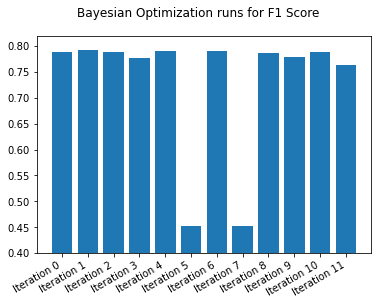

In [20]:
import matplotlib.pyplot as plt
import math
fig, ax = plt.subplots(1, 1)

plt.ylim([0.4, 0.82])
fig.suptitle('Bayesian Optimization runs for F1 Score')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.bar(bayes_params, bayes_values)
print('best params: {}'.format(optimizer.max))

In [21]:
def train_model_save(adam=0,lr=0.001,epochs=5):
    # use base adam if adam <=0.5 otherwise use adamW with weight decay
    model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data.copy_(pretrained_embeddings)
    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
    model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
    optimizer = optim.Adam(model.parameters(),lr=lr) if adam<=0.5 else optim.AdamW(model.parameters(),lr=lr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([CLASS_WEIGHT]))
    model = model.to(device)
    criterion = criterion.to(device)
    N_EPOCHS = round(epochs)
    start_time = time.time()

    best_valid_f1 = 0

    for epoch in tqdm(range(N_EPOCHS)):

        start_time = time.time()

        train_loss, train_acc, t_preds, t_labels = train(model, train_iter, optimizer, criterion)
        valid_loss, valid_acc, v_preds, v_labels = evaluate(model, val_iter, criterion)
        
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        f1 = f1_score(v_labels, v_preds, average="macro")
        print('F1: {}'.format(f1))
        print('Precision: {}'.format(precision_score(v_labels, v_preds, average="macro")))
        print('Recall: {}'.format(recall_score(v_labels, v_preds, average="macro")))
        if f1 > best_valid_f1:
            best_valid_f1 = f1
            torch.save(model.state_dict(), 'sentiment.pt')

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    return model

In [22]:
model = train_model_save(adam= optimizer.max['params']['adam'], lr=optimizer.max['params']['lr'],
                 epochs=optimizer.max['params']['epochs'])

  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.774827482830577
Precision: 0.8438028274591864
Recall: 0.7375984860713973
Epoch: 01 | Epoch Time: 1m 43s
	Train Loss: 0.086 | Train Acc: 83.86%
	 Val. Loss: 0.282 |  Val. Acc: 88.97%
F1: 0.7837667886561469
Precision: 0.8302397710598322
Recall: 0.7541330689458301
Epoch: 02 | Epoch Time: 1m 42s
	Train Loss: 0.072 | Train Acc: 85.00%
	 Val. Loss: 0.333 |  Val. Acc: 88.95%
F1: 0.7879235833256676
Precision: 0.8257099368771059
Recall: 0.762043608221715
Epoch: 03 | Epoch Time: 1m 42s
	Train Loss: 0.070 | Train Acc: 85.29%
	 Val. Loss: 0.328 |  Val. Acc: 88.97%
F1: 0.7887187822705499
Precision: 0.8223309561184158
Recall: 0.7648937443925012
Epoch: 04 | Epoch Time: 1m 42s
	Train Loss: 0.070 | Train Acc: 85.45%
	 Val. Loss: 0.360 |  Val. Acc: 88.91%
F1: 0.7860414154342197
Precision: 0.8261085325961486
Recall: 0.7591493932511375
Epoch: 05 | Epoch Time: 1m 42s
	Train Loss: 0.070 | Train Acc: 85.54%
	 Val. Loss: 0.359 |  Val. Acc: 88.92%
F1: 0.7813282306833309
Precision: 0.8240098937561783
Reca

In [24]:
model.load_state_dict(torch.load('sentiment.pt'))
criterion = nn.BCEWithLogitsLoss()
test_loss, test_acc, t_preds, t_labels = evaluate(model, test_iter, criterion)
f1 = f1_score(t_labels, t_preds, average="macro")
print('F1: {}'.format(f1))
print('Precision: {}'.format(precision_score(t_labels, t_preds, average="macro")))
print('Recall: {}'.format(recall_score(t_labels, t_preds, average="macro")))
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

F1: 0.7914951466869681
Precision: 0.8030659396188283
Recall: 0.7814061245798196
Test Loss: 1.091 | Test Acc: 88.43%


In [25]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = generate_bigrams([tok.text for tok in nlp.tokenizer(sentence)])
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [28]:
predict_sentiment(model, "this is bad")

1.0

In [27]:
predict_sentiment(model, "I am so impressed with this item")

1.0

# Problems
- Some words are not processed correctly: with f1 score tuning sentiments seem to be reversed?

In [ ]:
import pandas as pd
df= pd.read_csv("Tokenized.csv")
df.head()

In [ ]:
df["Prediction"]= df["Text"].map(lambda x:predict_sentiment(model, x))

In [ ]:
df["Scaled_Prediction"]= df.apply(lambda row:(row['Prediction']*row['Helpfulness']), axis=1)

In [ ]:
df.head()

In [ ]:
df.to_csv("results.csv",index=False)

In [ ]:
df.Rating.value_counts()